<a href="https://colab.research.google.com/github/prathameshPatil1606/diabetesprediction/blob/main/diabetesprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name = Diabetes Prediction (Ai Project)

**Importing Libraries**

Essential libraries for data manipulation, visualization, machine learning, and evaluation are imported.


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import joblib


**Load and Preview Dataset**

The dataset is loaded and basic information such as the shape, class distribution, and first few rows is displayed.


In [110]:
diabetes_dataset = pd.read_csv('diabetes.csv')
print("First 5 Rows:\n", diabetes_dataset.head())

First 5 Rows:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


Dataset Shape: (768, 9)
Class Distribution:
 Outcome
0    500
1    268
Name: count, dtype: int64


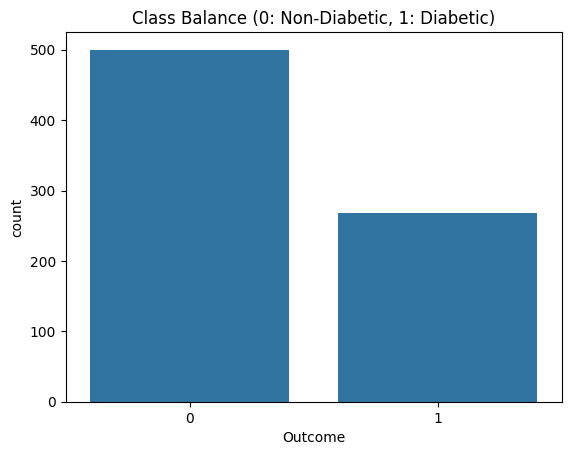

In [111]:
print("Dataset Shape:", diabetes_dataset.shape)
print("Class Distribution:\n", diabetes_dataset['Outcome'].value_counts())

sns.countplot(x='Outcome', data=diabetes_dataset)
plt.title('Class Balance (0: Non-Diabetic, 1: Diabetic)')
plt.show()


**Statistical Summary and Correlation Matrix**

Shows statistical properties of each feature and their correlations to understand feature relationships.



In [112]:
print("\nStatistical Info:\n", diabetes_dataset.describe())


Statistical Info:
        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.0000

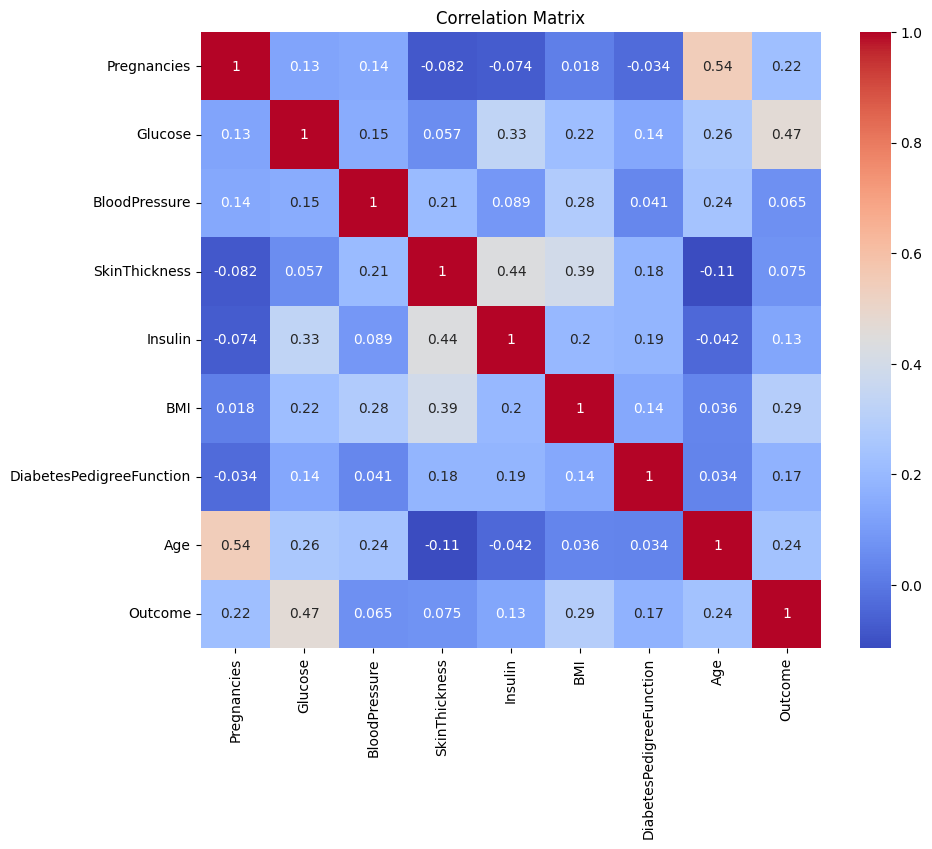

In [113]:
plt.figure(figsize=(10, 8))
sns.heatmap(diabetes_dataset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


**Feature and Target Split + Scaling**

Splits the dataset into features (X) and target (Y), then applies standard scaling to normalize feature values.

In [114]:
X = diabetes_dataset.drop('Outcome', axis=1)
Y = diabetes_dataset['Outcome']

In [115]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Train-Test Split**

The dataset is split into training and testing sets, preserving the class ratio using stratified sampling.

In [116]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, stratify=Y, random_state=2
)


**SMOTE for Balancing Classes**

SMOTE oversamples the minority class in the training data to balance the number of diabetic and non-diabetic samples.

In [117]:
smote = SMOTE(random_state=2)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)
print("After SMOTE:\n", pd.Series(Y_train_smote).value_counts())

After SMOTE:
 Outcome
1    400
0    400
Name: count, dtype: int64


**Grid Search for Hyperparameter Tuning**

Performs a grid search to find the best combination of Random Forest hyperparameters using cross-validation.



In [118]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 4]
}

rf = RandomForestClassifier(random_state=2)
grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_smote, Y_train_smote)
best_rf = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 8, 'min_samples_split': 4, 'n_estimators': 100}


In [119]:
cv_scores = cross_val_score(best_rf, X_scaled, Y, cv=5)
print("CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

CV Accuracy Scores: [0.77922078 0.70779221 0.75974026 0.83006536 0.76470588]
Mean CV Accuracy: 0.7683048977166624


**Model Evaluation on Train and Test Sets**

Calculates and prints the accuracy on training and test datasets to check for overfitting or underfitting.



In [120]:
train_preds = best_rf.predict(X_train_smote)
test_preds = best_rf.predict(X_test)

print("Training Accuracy:", accuracy_score(Y_train_smote, train_preds))
print("Test Accuracy:", accuracy_score(Y_test, test_preds))

print("\nClassification Report:\n", classification_report(Y_test, test_preds))


Training Accuracy: 0.95
Test Accuracy: 0.7532467532467533

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.64      0.69      0.66        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.76       154



** Confusion Matrix Visualization**

Plots the confusion matrix to show true positives, false positives, true negatives, and false negatives.

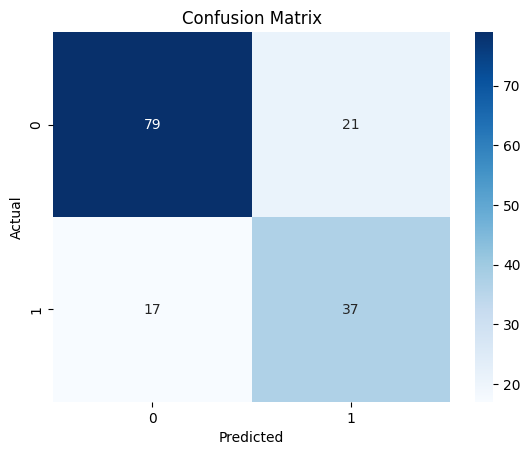

In [121]:
cm = confusion_matrix(Y_test, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**ROC Curve and AUC Score**

Draws the ROC curve to visualize the trade-off between sensitivity and specificity and calculates AUC.



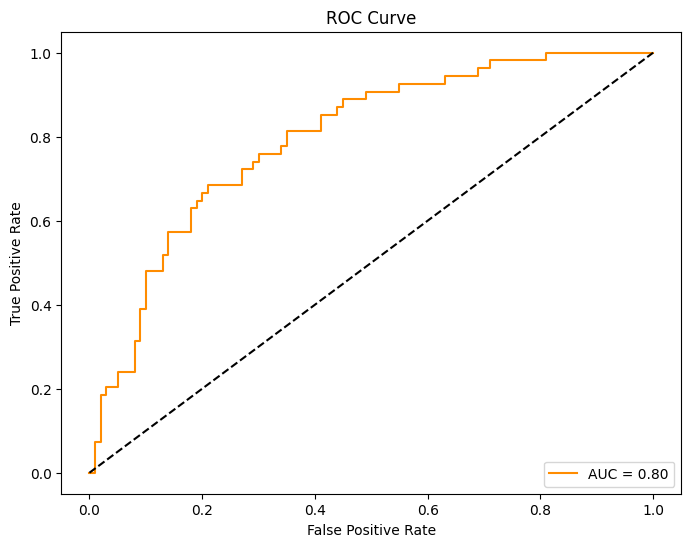

In [122]:
probs = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()

**Feature Importance Plot**

Displays the importance of each feature in the model’s decision-making process.

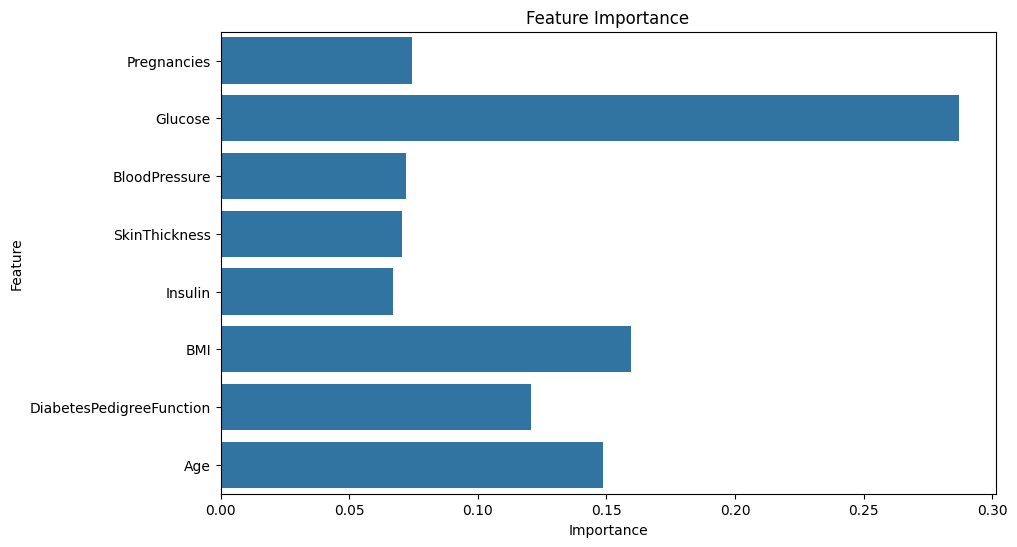

In [123]:
importances = best_rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



**Diabetes Prediction**

This section performs a  diabetes prediction. It takes input features for one person, preprocesses them (reshaping and scaling), and uses the trained Random Forest model to predict whether the person is diabetic or not. The result is printed as a clear message.

--> The person is Diabetes (1)

--> The person is not Diabetes (0)



In [124]:
#input_data = (Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age)
input_data = (6,148,72,35,0,33.6,0.627,50)
input_array = np.asarray(input_data).reshape(1, -1)
input_df = pd.DataFrame(input_array, columns=X.columns)
input_scaled = scaler.transform(input_df)

prediction = best_rf.predict(input_scaled)

if prediction[0] == 1:
    print("The person is diabetic")
else:
    print("The person is not diabetic")


The person is diabetic
